In [51]:
import numpy as np
import pandas as pd
from scipy.spatial import distance 
from sklearn.utils import validation
from sklearn.metrics import pairwise
from scipy.sparse import issparse
from scipy.cluster.hierarchy import dendrogram, linkage,fcluster
from matplotlib import pyplot as plt
from scipy.spatial.distance import squareform 
from scipy import cluster
from scipy.stats import mode
from sklearn.metrics import accuracy_score
from sklearn.metrics import adjusted_rand_score
from sklearn.metrics import confusion_matrix
from sklearn import metrics
import seaborn as sns
from scipy.cluster.hierarchy import cophenet
np.set_printoptions(precision=5, suppress=True)
import warnings
from sklearn.cluster import AgglomerativeClustering
from sklearn.cluster import KMeans, AgglomerativeClustering, AffinityPropagation #For clustering
from sklearn.mixture import GaussianMixture #For GMM clustering
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from sklearn.cluster import SpectralClustering
from sklearn.cluster import DBSCAN
warnings.filterwarnings('ignore')

In [38]:
def show_output(label,target,method, k):
    """
    Performs appropiate permutation
    Calculates overlap and confusion matrix
    
    Parameters:
    ----------
        label: cluster group predicted by cluster algorithm
        target: benchmark cluster group
        method: method used for clustering
        
    """
    # label = y_pred
    # target = y_true


    labels = np.zeros_like(label)
    for i in range(10):
        mask = (label == i)
        labels[mask] = mode(target[mask])[0]
    
     
    print("Method: %s"%(method))
    print("Percentage overlap with default clustering:%0.3f"%(accuracy_score(target,labels)))
    print("Homogeneity: %0.3f" % metrics.homogeneity_score(target, labels))
    print("Completeness: %0.3f" % metrics.completeness_score(target, labels))
    print("V-measure: %0.3f" % metrics.v_measure_score(target, labels))

In [39]:
def kmeans_clust(nb_clust, inputDataset, algo='full'):
    kmeans = KMeans(n_clusters=nb_clust, random_state=0, algorithm=algo)
    clusters = kmeans.fit_predict(inputDataset)
    return clusters, kmeans

In [40]:
kclust = 4

In [85]:
from pandas import read_excel
from sklearn.preprocessing import MinMaxScaler
# Lecture du fichier des nouveaux groupes fonctionnels
file_name = '../data/Nouveau_groupes_fonctionnels.xlsx' # name of your excel file
data_gf = read_excel(file_name, sheet_name = 'data_GF')
imputed_data = read_excel(file_name, sheet_name = 'data_imp')
trait_mice = read_excel(file_name, sheet_name = 'data_NA')
trait_mice.set_index('Code',inplace=True)
trait_nona = trait_mice.dropna(axis = 0, how ='any')
trait_nona = trait_nona[['log_seedmass','WD','SLA','Nmass']] #without A.G

target = pd.Series(data_gf['GF4'])

train_cols = list(trait_mice.select_dtypes(include=[np.float]))
imputed_data.iloc[:,2:6].head()
dataset_to_cluster = imputed_data.iloc[:,2:6]
dataset_with_ag_to_cluster = imputed_data.iloc[:,2:7]

#Since the clustering is sensitive to range of data. It is advisable to scale the data before proceeding.
scaler = MinMaxScaler(feature_range=(0,1))

scaled_df = scaler.fit_transform(dataset_to_cluster)
dataset_to_cluster = pd.DataFrame(scaled_df, columns=dataset_to_cluster.columns.values.tolist())
#print(target)
dataset_to_cluster.head()

log_seedmass        WD       SLA     Nmass
0      0.333585  0.187931  0.170162  0.065292
1      0.455502  0.155172  0.139437  0.070103
2      0.431857  0.637931  0.602824  0.347079
3      0.453391  0.453448  0.574307  0.573196
4      0.456124  0.224138  0.689792  0.483162

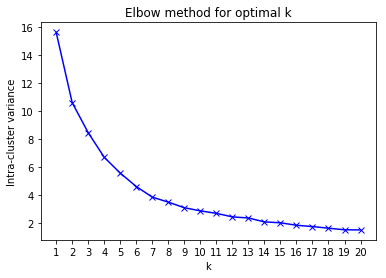

In [86]:
#Before begining, we try to found the optimal number of clusters for only the numerical values
Sum_of_squared_distances = []
K = range(1,21)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(dataset_to_cluster)
    Sum_of_squared_distances.append(km.inertia_)

plt.xticks(K)
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Intra-cluster variance')
plt.title('Elbow method for optimal k')
plt.show()

For n_clusters = 2, silhouette score is 0.2976299970738256)
For n_clusters = 3, silhouette score is 0.3116672001837602)
For n_clusters = 4, silhouette score is 0.32643109887894217)
For n_clusters = 5, silhouette score is 0.32857641324929293)
For n_clusters = 6, silhouette score is 0.343160369616445)
For n_clusters = 7, silhouette score is 0.36194117799458314)
For n_clusters = 8, silhouette score is 0.36459611760588423)
For n_clusters = 9, silhouette score is 0.3547393948084275)
For n_clusters = 10, silhouette score is 0.34858701792738206)
For n_clusters = 11, silhouette score is 0.35222518425898774)
For n_clusters = 12, silhouette score is 0.32806877509206794)
For n_clusters = 13, silhouette score is 0.3167433811787598)
For n_clusters = 14, silhouette score is 0.3256236321357601)
For n_clusters = 15, silhouette score is 0.305346245633815)
For n_clusters = 16, silhouette score is 0.31261531465560083)
For n_clusters = 17, silhouette score is 0.2971311075443784)
For n_clusters = 18, silho

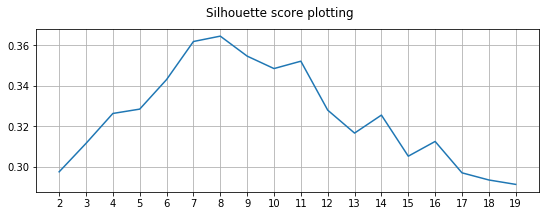

In [87]:
from sklearn.metrics import silhouette_score
score_list = []
for n_clusters in range(2,20):
    clusterer = KMeans (n_clusters=n_clusters)
    preds = clusterer.fit_predict(dataset_to_cluster)
    centers = clusterer.cluster_centers_

    score = silhouette_score(dataset_to_cluster, preds, metric='euclidean')
    score_list.append(score)
    print ("For n_clusters = {}, silhouette score is {})".format(n_clusters, score))
    
names = range(2,20)
values = score_list


plt.figure(figsize=(9, 3))

plt.subplot(111)
plt.plot(names, values)
plt.suptitle('Silhouette score plotting')
plt.grid(True)
plt.xticks(names)
plt.show()

In [88]:
clusters, kmeans = kmeans_clust(4,dataset_to_cluster, 'full')
show_output(clusters,target,'KMeans', kclust)

Method: KMeans
Percentage overlap with default clustering:0.878
Homogeneity: 0.754
Completeness: 0.730
V-measure: 0.742


In [89]:
gmm = GaussianMixture(n_components=kclust,covariance_type='full',random_state=7)
gmm.fit(dataset_to_cluster)
old_label = gmm.predict(dataset_to_cluster) 
#print(old_label)

show_output(old_label,target,'Gaussian Mixture', kclust)

Method: Gaussian Mixture
Percentage overlap with default clustering:0.800
Homogeneity: 0.650
Completeness: 0.835
V-measure: 0.731


In [90]:
model = SpectralClustering(n_clusters=kclust, affinity='nearest_neighbors',
                           assign_labels='discretize')
clusters = model.fit_predict(dataset_to_cluster)
show_output(clusters,target,'SpectralClustering', kclust)

Method: SpectralClustering
Percentage overlap with default clustering:0.867
Homogeneity: 0.711
Completeness: 0.692
V-measure: 0.701


In [91]:
def doAgglomerative(inputData, nclust=kclust, aff='euclidean', link='ward'):
    model = AgglomerativeClustering(n_clusters=nclust, affinity = aff, linkage = link)
    clust_labels1 = model.fit_predict(inputData)
    return (clust_labels1)

clusters = doAgglomerative(dataset_to_cluster, kclust)
show_output(clusters,target,'AgglomerativeClustering', kclust)

Method: AgglomerativeClustering
Percentage overlap with default clustering:0.800
Homogeneity: 0.650
Completeness: 0.835
V-measure: 0.731


In [92]:
#assign weights to traits like allain in his R script
#since the traits can be ordinal, nominal or numeric; calculate gower distance matrix  
weights = np.array([1,1,1,1,1])
D = gower_distances(imputed_data.iloc[:,2:7],feature_weight=weights)
print(D)

[False False False False  True]
[[0.      0.03804 0.45254 ... 0.5046  0.38458 0.05701]
 [0.03804 0.      0.44935 ... 0.49195 0.37193 0.03399]
 [0.45254 0.44935 0.      ... 0.06585 0.13408 0.45114]
 ...
 [0.5046  0.49195 0.06585 ... 0.      0.1283  0.4756 ]
 [0.38458 0.37193 0.13408 ... 0.1283  0.      0.35951]
 [0.05701 0.03399 0.45114 ... 0.4756  0.35951 0.     ]]


In [93]:
#DbScan is not adapted to our dataset, we know the number of clusters we want and that we have no noise points
#X = dataset_to_cluster
X = D
# Compute DBSCAN

db = DBSCAN(eps=0.23, min_samples = 10, metric='precomputed').fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)
n_noise_ = list(labels).count(-1)

print('Estimated number of clusters: %d' % n_clusters_)
print('Estimated number of noise points: %d' % n_noise_)
print("V-measure: %0.3f" % metrics.v_measure_score(target, labels))
print("Adjusted Rand Index: %0.3f"
      % metrics.adjusted_rand_score(target, labels))
print("Adjusted Mutual Information: %0.3f"
      % metrics.adjusted_mutual_info_score(target, labels,
                                           average_method='arithmetic'))

Estimated number of clusters: 2
Estimated number of noise points: 0
V-measure: 0.570
Adjusted Rand Index: 0.349
Adjusted Mutual Information: 0.561


In [94]:
from kmodes.kprototypes import KPrototypes
kproto = KPrototypes(n_clusters=kclust, init='Cao', n_init=1000, verbose=2)

clusters = kproto.fit_predict(dataset_with_ag_to_cluster, categorical=[4])

# Print cluster centroids of the trained model.
#print(kproto.cluster_centroids_)
# Print training statistics
#print(kproto.cost_)
#print(kproto.n_iter_)
show_output(clusters,target,'KPrototypes', kclust)

Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 5, ncost: 2793.7073802346813
Run: 1, iteration: 2/100, moves: 1, ncost: 2789.0311485464954
Run: 1, iteration: 3/100, moves: 0, ncost: 2789.0311485464954
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 15, ncost: 2447.7910512576896
Run: 2, iteration: 2/100, moves: 5, ncost: 2392.245816088529
Run: 2, iteration: 3/100, moves: 7, ncost: 2318.1888797773627
Run: 2, iteration: 4/100, moves: 1, ncost: 2314.2713949453396
Run: 2, iteration: 5/100, moves: 2, ncost: 2306.3183381408285
Run: 2, iteration: 6/100, moves: 5, ncost: 2267.521165748525
Run: 2, iteration: 7/100, moves: 3, ncost: 2256.1133029779444
Run: 2, iteration: 8/100, moves: 0, ncost: 2256.1133029779444
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/1

Run: 25, iteration: 2/100, moves: 7, ncost: 2234.6390501305623
Run: 25, iteration: 3/100, moves: 1, ncost: 2231.996713450057
Run: 25, iteration: 4/100, moves: 0, ncost: 2231.996713450057
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 26, iteration: 1/100, moves: 13, ncost: 2415.26493954998
Run: 26, iteration: 2/100, moves: 8, ncost: 2320.9477047209307
Run: 26, iteration: 3/100, moves: 2, ncost: 2314.271394945338
Run: 26, iteration: 4/100, moves: 2, ncost: 2306.3183381408267
Run: 26, iteration: 5/100, moves: 5, ncost: 2267.5211657485243
Run: 26, iteration: 6/100, moves: 3, ncost: 2256.1133029779435
Run: 26, iteration: 7/100, moves: 0, ncost: 2256.1133029779435
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 27, iteration: 1/100, moves: 13, ncost: 2379.4161424080567
Run: 27, iteration: 2/100, moves: 6, ncost: 2312.288504990568
Run: 27, iteration: 3/100, moves: 1, ncost: 2310.3794797006017
Run: 27, iteration: 4/100

Starting iterations...
Run: 52, iteration: 1/100, moves: 6, ncost: 2313.052093860146
Run: 52, iteration: 2/100, moves: 3, ncost: 2268.3272979054586
Run: 52, iteration: 3/100, moves: 1, ncost: 2261.2236235402283
Run: 52, iteration: 4/100, moves: 0, ncost: 2261.2236235402283
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 53, iteration: 1/100, moves: 21, ncost: 2634.0813101036647
Run: 53, iteration: 2/100, moves: 8, ncost: 2530.1449583827666
Run: 53, iteration: 3/100, moves: 2, ncost: 2520.9633382618567
Run: 53, iteration: 4/100, moves: 0, ncost: 2520.9633382618567
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 54, iteration: 1/100, moves: 31, ncost: 2467.1435667796036
Run: 54, iteration: 2/100, moves: 11, ncost: 2252.5130023279353
Run: 54, iteration: 3/100, moves: 2, ncost: 2243.1614706391033
Run: 54, iteration: 4/100, moves: 0, ncost: 2243.1614706391033
Init: initializing centroids
Init: initializing clusters
St

Run: 82, iteration: 2/100, moves: 6, ncost: 2233.071861714279
Run: 82, iteration: 3/100, moves: 0, ncost: 2233.071861714279
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 83, iteration: 1/100, moves: 17, ncost: 2816.8680134584947
Run: 83, iteration: 2/100, moves: 3, ncost: 2773.3260873868035
Run: 83, iteration: 3/100, moves: 0, ncost: 2773.3260873868035
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 84, iteration: 1/100, moves: 14, ncost: 2286.950833826885
Run: 84, iteration: 2/100, moves: 6, ncost: 2243.543468958592
Run: 84, iteration: 3/100, moves: 0, ncost: 2243.543468958592
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 85, iteration: 1/100, moves: 26, ncost: 2868.2839941663296
Run: 85, iteration: 2/100, moves: 19, ncost: 2566.1521289055204
Run: 85, iteration: 3/100, moves: 2, ncost: 2557.755560520549
Run: 85, iteration: 4/100, moves: 0, ncost: 2557.755560520549
Init: i

Starting iterations...
Run: 108, iteration: 1/100, moves: 10, ncost: 2295.211433462441
Run: 108, iteration: 2/100, moves: 1, ncost: 2290.884816481892
Run: 108, iteration: 3/100, moves: 0, ncost: 2290.884816481892
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 109, iteration: 1/100, moves: 26, ncost: 2913.906984923485
Run: 109, iteration: 2/100, moves: 16, ncost: 2671.8415301891755
Run: 109, iteration: 3/100, moves: 10, ncost: 2543.8878989076234
Run: 109, iteration: 4/100, moves: 3, ncost: 2530.0401991551826
Run: 109, iteration: 5/100, moves: 0, ncost: 2530.0401991551826
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 110, iteration: 1/100, moves: 13, ncost: 3047.5351126510163
Run: 110, iteration: 2/100, moves: 9, ncost: 2879.905510591166
Run: 110, iteration: 3/100, moves: 14, ncost: 2490.8689201156103
Run: 110, iteration: 4/100, moves: 11, ncost: 2271.7717

Run: 136, iteration: 1/100, moves: 17, ncost: 2635.0726679386735
Run: 136, iteration: 2/100, moves: 10, ncost: 2530.144958382767
Run: 136, iteration: 3/100, moves: 2, ncost: 2520.9633382618567
Run: 136, iteration: 4/100, moves: 0, ncost: 2520.9633382618567
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 137, iteration: 1/100, moves: 12, ncost: 2401.6026545736304
Run: 137, iteration: 2/100, moves: 9, ncost: 2248.30586338147
Run: 137, iteration: 3/100, moves: 2, ncost: 2237.8903523860795
Run: 137, iteration: 4/100, moves: 0, ncost: 2237.8903523860795
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 138, iteration: 1/100, moves: 10, ncost: 2287.033019246358
Run: 138, iteration: 2/100, moves: 5, ncost: 2243.1614706391024
Run: 138, iteration: 3/100, moves: 0, ncost: 2243.1614706391024
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...

Run: 163, iteration: 2/100, moves: 6, ncost: 2299.783075569848
Run: 163, iteration: 3/100, moves: 5, ncost: 2261.216677875914
Run: 163, iteration: 4/100, moves: 4, ncost: 2243.5434689585923
Run: 163, iteration: 5/100, moves: 0, ncost: 2243.5434689585923
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 164, iteration: 1/100, moves: 20, ncost: 2277.560839581524
Run: 164, iteration: 2/100, moves: 3, ncost: 2261.223623540229
Run: 164, iteration: 3/100, moves: 0, ncost: 2261.223623540229
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 165, iteration: 1/100, moves: 26, ncost: 2301.8514044090657
Run: 165, iteration: 2/100, moves: 4, ncost: 2261.223623540229
Run: 165, iteration: 3/100, moves: 0, ncost: 2261.223623540229
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 166, iteration: 1/100, moves: 16, ncost: 2445.434391126951
Run: 166, iteration: 2/100, moves: 10, ncost: 2278.6337422237

Run: 195, iteration: 4/100, moves: 12, ncost: 2534.9228176363144
Run: 195, iteration: 5/100, moves: 3, ncost: 2520.963338261856
Run: 195, iteration: 6/100, moves: 0, ncost: 2520.963338261856
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 196, iteration: 1/100, moves: 19, ncost: 2975.218211799174
Run: 196, iteration: 2/100, moves: 5, ncost: 2897.628265642154
Run: 196, iteration: 3/100, moves: 7, ncost: 2751.464133906238
Run: 196, iteration: 4/100, moves: 8, ncost: 2606.5601383678786
Run: 196, iteration: 5/100, moves: 4, ncost: 2569.26100442085
Run: 196, iteration: 6/100, moves: 0, ncost: 2569.26100442085
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 197, iteration: 1/100, moves: 21, ncost: 2355.490273896374
Run: 197, iteration: 2/100, moves: 9, ncost: 2254.1970336714116
Run: 197, iteration: 3/100, moves: 2, ncost: 2243.5434689585927
Run: 197, iteration: 4/100, moves: 0, ncost: 2243.5434689585927
Init: initializ

Run: 222, iteration: 6/100, moves: 3, ncost: 2256.113302977944
Run: 222, iteration: 7/100, moves: 0, ncost: 2256.113302977944
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 223, iteration: 1/100, moves: 8, ncost: 2553.3390406619083
Run: 223, iteration: 2/100, moves: 7, ncost: 2272.424875649401
Run: 223, iteration: 3/100, moves: 3, ncost: 2246.155085908165
Run: 223, iteration: 4/100, moves: 0, ncost: 2246.155085908165
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 224, iteration: 1/100, moves: 22, ncost: 2918.5606765201055
Run: 224, iteration: 2/100, moves: 12, ncost: 2654.830190824712
Run: 224, iteration: 3/100, moves: 9, ncost: 2530.1449583827657
Run: 224, iteration: 4/100, moves: 2, ncost: 2520.9633382618567
Run: 224, iteration: 5/100, moves: 0, ncost: 2520.9633382618567
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 225, iteration: 1/100, moves: 23, ncost: 2395.869078320

Run: 250, iteration: 4/100, moves: 0, ncost: 2310.3794797006008
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 251, iteration: 1/100, moves: 15, ncost: 2399.4035925595335
Run: 251, iteration: 2/100, moves: 5, ncost: 2326.419745390979
Run: 251, iteration: 3/100, moves: 3, ncost: 2310.3794797006008
Run: 251, iteration: 4/100, moves: 0, ncost: 2310.3794797006008
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 252, iteration: 1/100, moves: 18, ncost: 2596.7404606208897
Run: 252, iteration: 2/100, moves: 4, ncost: 2569.2610044208495
Run: 252, iteration: 3/100, moves: 0, ncost: 2569.2610044208495
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 253, iteration: 1/100, moves: 24, ncost: 2337.424326094545
Run: 253, iteration: 2/100, moves: 8, ncost: 2244.8630564548826
Run: 253, iteration: 3/100, moves: 2, ncost: 2233.071861714279

Run: 281, iteration: 5/100, moves: 0, ncost: 2243.5434689585923
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 282, iteration: 1/100, moves: 9, ncost: 2267.3555549830144
Run: 282, iteration: 2/100, moves: 4, ncost: 2231.996713450056
Run: 282, iteration: 3/100, moves: 0, ncost: 2231.996713450056
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 283, iteration: 1/100, moves: 12, ncost: 3024.4930007224343
Run: 283, iteration: 2/100, moves: 18, ncost: 2523.398903894706
Run: 283, iteration: 3/100, moves: 10, ncost: 2349.8844566905705
Run: 283, iteration: 4/100, moves: 5, ncost: 2305.3461514322003
Run: 283, iteration: 5/100, moves: 0, ncost: 2305.3461514322003
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 284, iteration: 1/100, moves: 13, ncost: 2350.882885000447
Run: 284, iteration: 2/100, moves: 3, ncost: 2315.4945716427637
Run: 284, iteration: 3/100, moves: 4, ncost: 2290.780880

Run: 331, iteration: 3/100, moves: 0, ncost: 2230.6637495352875
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 332, iteration: 1/100, moves: 27, ncost: 2330.4158924835815
Run: 332, iteration: 2/100, moves: 6, ncost: 2261.223623540229
Run: 332, iteration: 3/100, moves: 0, ncost: 2261.223623540229
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 333, iteration: 1/100, moves: 32, ncost: 2529.041940268512
Run: 333, iteration: 2/100, moves: 11, ncost: 2269.776807223445
Run: 333, iteration: 3/100, moves: 3, ncost: 2237.833259213593
Run: 333, iteration: 4/100, moves: 1, ncost: 2233.071861714278
Run: 333, iteration: 5/100, moves: 0, ncost: 2233.071861714278
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 334, iteration: 1/100, moves: 27, ncost: 2977.734412335885
Run: 334, iteration: 2/100, moves: 17, ncost: 2636.8666330760375
Run: 334, iteration: 3/100, moves: 7, ncost: 2445.422801321

Run: 358, iteration: 6/100, moves: 1, ncost: 2240.9977717041484
Run: 358, iteration: 7/100, moves: 0, ncost: 2240.9977717041484
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 359, iteration: 1/100, moves: 7, ncost: 2569.261004420849
Run: 359, iteration: 2/100, moves: 0, ncost: 2569.261004420849
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 360, iteration: 1/100, moves: 21, ncost: 2577.496762789752
Run: 360, iteration: 2/100, moves: 2, ncost: 2572.1251573157465
Run: 360, iteration: 3/100, moves: 0, ncost: 2572.1251573157465
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 361, iteration: 1/100, moves: 22, ncost: 2542.4140570846275
Run: 361, iteration: 2/100, moves: 12, ncost: 2284.679718848395
Run: 361, iteration: 3/100, moves: 4, ncost: 2244.863056454882
Run: 361, iteration: 4/100, moves: 2, ncost: 2233.071861714279
Run: 361, iteration: 5/100, moves: 0, ncost: 2233.071861714

Run: 386, iteration: 4/100, moves: 0, ncost: 2243.5434689585923
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 387, iteration: 1/100, moves: 27, ncost: 2639.687442419924
Run: 387, iteration: 2/100, moves: 15, ncost: 2327.9927553990897
Run: 387, iteration: 3/100, moves: 6, ncost: 2262.962173754114
Run: 387, iteration: 4/100, moves: 1, ncost: 2260.0462144706576
Run: 387, iteration: 5/100, moves: 0, ncost: 2260.0462144706576
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 388, iteration: 1/100, moves: 16, ncost: 2291.3836273930174
Run: 388, iteration: 2/100, moves: 4, ncost: 2237.8332592135926
Run: 388, iteration: 3/100, moves: 1, ncost: 2233.0718617142784
Run: 388, iteration: 4/100, moves: 0, ncost: 2233.0718617142784
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 389, iteration: 1/100, moves: 24, ncost: 2533.98599744016
Run: 389, iteration: 2/100, moves: 9, ncost: 2339.811945

Run: 412, iteration: 3/100, moves: 8, ncost: 2333.48128629898
Run: 412, iteration: 4/100, moves: 3, ncost: 2304.8829743931105
Run: 412, iteration: 5/100, moves: 2, ncost: 2290.3846255218573
Run: 412, iteration: 6/100, moves: 0, ncost: 2290.3846255218573
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 413, iteration: 1/100, moves: 13, ncost: 2748.3434606046926
Run: 413, iteration: 2/100, moves: 6, ncost: 2698.4838367611283
Run: 413, iteration: 3/100, moves: 9, ncost: 2539.3239580164413
Run: 413, iteration: 4/100, moves: 14, ncost: 2329.8460881507253
Run: 413, iteration: 5/100, moves: 7, ncost: 2277.96538903247
Run: 413, iteration: 6/100, moves: 4, ncost: 2245.971798995652
Run: 413, iteration: 7/100, moves: 1, ncost: 2240.9977717041475
Run: 413, iteration: 8/100, moves: 0, ncost: 2240.9977717041475
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 414, iteration: 1/100, moves: 19, ncost: 3034.980540013833
Run: 414, i

Starting iterations...
Run: 436, iteration: 1/100, moves: 28, ncost: 2317.9007887432454
Run: 436, iteration: 2/100, moves: 2, ncost: 2310.3794797006017
Run: 436, iteration: 3/100, moves: 0, ncost: 2310.3794797006017
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 437, iteration: 1/100, moves: 21, ncost: 2354.1599277449322
Run: 437, iteration: 2/100, moves: 4, ncost: 2266.0815999020165
Run: 437, iteration: 3/100, moves: 3, ncost: 2231.9967134500566
Run: 437, iteration: 4/100, moves: 0, ncost: 2231.9967134500566
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 438, iteration: 1/100, moves: 15, ncost: 2994.3388291749443
Run: 438, iteration: 2/100, moves: 15, ncost: 2510.1917224653043
Run: 438, iteration: 3/100, moves: 10, ncost: 2315.4216420460675
Run: 438, iteration: 4/100, moves: 7, ncost: 2237.833259213593
Run: 438, iteration: 5/100, moves: 1, ncost: 2233.07

Run: 465, iteration: 2/100, moves: 7, ncost: 2335.252616725075
Run: 465, iteration: 3/100, moves: 4, ncost: 2314.271394945338
Run: 465, iteration: 4/100, moves: 2, ncost: 2306.318338140828
Run: 465, iteration: 5/100, moves: 5, ncost: 2267.5211657485247
Run: 465, iteration: 6/100, moves: 3, ncost: 2256.1133029779435
Run: 465, iteration: 7/100, moves: 0, ncost: 2256.1133029779435
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 466, iteration: 1/100, moves: 17, ncost: 2450.7347358741576
Run: 466, iteration: 2/100, moves: 11, ncost: 2320.9477047209307
Run: 466, iteration: 3/100, moves: 2, ncost: 2314.2713949453387
Run: 466, iteration: 4/100, moves: 2, ncost: 2306.3183381408276
Run: 466, iteration: 5/100, moves: 5, ncost: 2267.5211657485247
Run: 466, iteration: 6/100, moves: 3, ncost: 2256.1133029779435
Run: 466, iteration: 7/100, moves: 0, ncost: 2256.1133029779435
Init: initializing centroids
Ini

Starting iterations...
Run: 489, iteration: 1/100, moves: 13, ncost: 2257.340052965039
Run: 489, iteration: 2/100, moves: 2, ncost: 2248.312086567198
Run: 489, iteration: 3/100, moves: 0, ncost: 2248.312086567198
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 490, iteration: 1/100, moves: 10, ncost: 3084.414949820826
Run: 490, iteration: 2/100, moves: 7, ncost: 2903.7454580762246
Run: 490, iteration: 3/100, moves: 7, ncost: 2798.828744951015
Run: 490, iteration: 4/100, moves: 3, ncost: 2773.326087386804
Run: 490, iteration: 5/100, moves: 0, ncost: 2773.326087386804
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 491, iteration: 1/100, moves: 20, ncost: 2577.4055419678375
Run: 491, iteration: 2/100, moves: 12, ncost: 2377.7328019257334
Run: 491, iteration: 3/100, moves: 9, ncost: 2298.9458116189207
Run: 491, iteration: 4/100, moves: 8, ncost: 2256.113302977944
Run: 491, iteration: 5/100, moves: 0, ncost: 2256.113

Run: 514, iteration: 1/100, moves: 11, ncost: 2258.2943623006254
Run: 514, iteration: 2/100, moves: 4, ncost: 2233.071861714279
Run: 514, iteration: 3/100, moves: 0, ncost: 2233.071861714279
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 515, iteration: 1/100, moves: 31, ncost: 2583.35148351219
Run: 515, iteration: 2/100, moves: 12, ncost: 2269.7768072234453
Run: 515, iteration: 3/100, moves: 3, ncost: 2237.833259213593
Run: 515, iteration: 4/100, moves: 1, ncost: 2233.0718617142784
Run: 515, iteration: 5/100, moves: 0, ncost: 2233.0718617142784
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 516, iteration: 1/100, moves: 11, ncost: 3368.038364831309
Run: 516, iteration: 2/100, moves: 15, ncost: 2864.485872255762
Run: 516, iteration: 3/100, moves: 7, ncost: 2751.892727786107
Run: 516, iteration: 4/100, moves: 12, ncost: 2534.922817636315
Run: 516, iteration: 5/100, moves: 3, ncost: 2520.9633382618563
Run: 516, i

Run: 541, iteration: 3/100, moves: 4, ncost: 2399.4035925595344
Run: 541, iteration: 4/100, moves: 5, ncost: 2326.419745390979
Run: 541, iteration: 5/100, moves: 3, ncost: 2310.379479700601
Run: 541, iteration: 6/100, moves: 0, ncost: 2310.379479700601
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 542, iteration: 1/100, moves: 28, ncost: 2930.1965344635037
Run: 542, iteration: 2/100, moves: 7, ncost: 2779.796050943987
Run: 542, iteration: 3/100, moves: 1, ncost: 2773.326087386805
Run: 542, iteration: 4/100, moves: 0, ncost: 2773.326087386805
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 543, iteration: 1/100, moves: 14, ncost: 2425.8470408340017
Run: 543, iteration: 2/100, moves: 13, ncost: 2254.1970336714116
Run: 543, iteration: 3/100, moves: 2, ncost: 2243.5434689585923
Run: 543, iteration: 4/100, moves: 0, ncost: 2243.5434689585923
Init: initializing centroids
Init: initializing clusters
Starting iteration

Run: 566, iteration: 9/100, moves: 0, ncost: 2260.0462144706576
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 567, iteration: 1/100, moves: 10, ncost: 2593.73229673726
Run: 567, iteration: 2/100, moves: 3, ncost: 2569.2610044208495
Run: 567, iteration: 3/100, moves: 0, ncost: 2569.2610044208495
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 568, iteration: 1/100, moves: 21, ncost: 2393.2129502966195
Run: 568, iteration: 2/100, moves: 10, ncost: 2250.8324491033845
Run: 568, iteration: 3/100, moves: 3, ncost: 2233.0718617142793
Run: 568, iteration: 4/100, moves: 0, ncost: 2233.0718617142793
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 569, iteration: 1/100, moves: 28, ncost: 2335.4079033246785
Run: 569, iteration: 2/100, moves: 7, ncost: 2272.9867027942496
Run: 569, iteration: 3/100, moves: 0, ncost: 2272.9867027942496
Init: initializing centroids
Init: initializing cluste

Run: 597, iteration: 4/100, moves: 6, ncost: 2615.1276607505815
Run: 597, iteration: 5/100, moves: 12, ncost: 2372.7714518449407
Run: 597, iteration: 6/100, moves: 6, ncost: 2289.5440079236873
Run: 597, iteration: 7/100, moves: 4, ncost: 2262.962173754113
Run: 597, iteration: 8/100, moves: 1, ncost: 2260.046214470657
Run: 597, iteration: 9/100, moves: 0, ncost: 2260.046214470657
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 598, iteration: 1/100, moves: 25, ncost: 2287.881839622934
Run: 598, iteration: 2/100, moves: 3, ncost: 2248.3120865671985
Run: 598, iteration: 3/100, moves: 0, ncost: 2248.3120865671985
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 599, iteration: 1/100, moves: 19, ncost: 2863.1686042965243
Run: 599, iteration: 2/100, moves: 3, ncost: 2828.2696335444252
Run: 599, iteration: 3/100, moves: 5, ncost: 2656.1221164093686
Run: 599, iteration: 4/100, moves: 3, ncost: 2578.5493542682957
Run: 599,

Run: 626, iteration: 2/100, moves: 6, ncost: 2290.780880767676
Run: 626, iteration: 3/100, moves: 8, ncost: 2243.5434689585923
Run: 626, iteration: 4/100, moves: 0, ncost: 2243.5434689585923
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 627, iteration: 1/100, moves: 13, ncost: 2394.0917919356098
Run: 627, iteration: 2/100, moves: 7, ncost: 2312.288504990568
Run: 627, iteration: 3/100, moves: 1, ncost: 2310.3794797006
Run: 627, iteration: 4/100, moves: 0, ncost: 2310.3794797006
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 628, iteration: 1/100, moves: 22, ncost: 3232.374238634933
Run: 628, iteration: 2/100, moves: 14, ncost: 2559.907862093564
Run: 628, iteration: 3/100, moves: 5, ncost: 2542.2906846482883
Run: 628, iteration: 4/100, moves: 0, ncost: 2542.2906846482883
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 629, iteration: 1/100, moves: 11, ncost: 2379.416142408056

Run: 655, iteration: 1/100, moves: 12, ncost: 2668.208660160722
Run: 655, iteration: 2/100, moves: 11, ncost: 2509.0781247086306
Run: 655, iteration: 3/100, moves: 10, ncost: 2342.201004131987
Run: 655, iteration: 4/100, moves: 3, ncost: 2327.3075980880603
Run: 655, iteration: 5/100, moves: 0, ncost: 2327.3075980880603
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 656, iteration: 1/100, moves: 19, ncost: 2358.932628192609
Run: 656, iteration: 2/100, moves: 10, ncost: 2254.1970336714116
Run: 656, iteration: 3/100, moves: 2, ncost: 2243.5434689585923
Run: 656, iteration: 4/100, moves: 0, ncost: 2243.5434689585923
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 657, iteration: 1/100, moves: 13, ncost: 2330.7705934112428
Run: 657, iteration: 2/100, moves: 2, ncost: 2318.6643490435986
Run: 657, iteration: 3/100, moves: 6, ncost: 2261.262687181714
Run: 657, iteration: 4/100, moves: 4, ncost: 2240.9977717041475
Run: 6

Run: 684, iteration: 3/100, moves: 5, ncost: 2531.412376958351
Run: 684, iteration: 4/100, moves: 1, ncost: 2520.9633382618567
Run: 684, iteration: 5/100, moves: 0, ncost: 2520.9633382618567
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 685, iteration: 1/100, moves: 19, ncost: 2548.968034910168
Run: 685, iteration: 2/100, moves: 3, ncost: 2533.0298444612495
Run: 685, iteration: 3/100, moves: 0, ncost: 2533.0298444612495
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 686, iteration: 1/100, moves: 22, ncost: 2515.030312313914
Run: 686, iteration: 2/100, moves: 9, ncost: 2318.7601144374003
Run: 686, iteration: 3/100, moves: 2, ncost: 2305.3461514322
Run: 686, iteration: 4/100, moves: 0, ncost: 2305.3461514322
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 687, iteration: 1/100, moves: 18, ncost: 2395.9961886234923
Run: 687, iteration: 2/100, moves: 6, ncost: 2315.494571642763

Starting iterations...
Run: 712, iteration: 1/100, moves: 25, ncost: 2335.6202531650683
Run: 712, iteration: 2/100, moves: 7, ncost: 2235.665739871358
Run: 712, iteration: 3/100, moves: 1, ncost: 2233.0718617142784
Run: 712, iteration: 4/100, moves: 0, ncost: 2233.0718617142784
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 713, iteration: 1/100, moves: 20, ncost: 2457.6937226018636
Run: 713, iteration: 2/100, moves: 7, ncost: 2399.403592559534
Run: 713, iteration: 3/100, moves: 5, ncost: 2326.4197453909796
Run: 713, iteration: 4/100, moves: 3, ncost: 2310.3794797006008
Run: 713, iteration: 5/100, moves: 0, ncost: 2310.3794797006008
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 714, iteration: 1/100, moves: 26, ncost: 3441.395324220272
Run: 714, iteration: 2/100, moves: 24, ncost: 2317.508607723826
Run: 714, iteration: 3/100, moves: 6, ncost: 2241.932489

Run: 741, iteration: 1/100, moves: 31, ncost: 2394.060361109311
Run: 741, iteration: 2/100, moves: 6, ncost: 2315.4945716427633
Run: 741, iteration: 3/100, moves: 4, ncost: 2290.780880767676
Run: 741, iteration: 4/100, moves: 8, ncost: 2243.5434689585927
Run: 741, iteration: 5/100, moves: 0, ncost: 2243.5434689585927
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 742, iteration: 1/100, moves: 26, ncost: 2431.780348381428
Run: 742, iteration: 2/100, moves: 9, ncost: 2314.565873507241
Run: 742, iteration: 3/100, moves: 4, ncost: 2290.780880767675
Run: 742, iteration: 4/100, moves: 8, ncost: 2243.543468958592
Run: 742, iteration: 5/100, moves: 0, ncost: 2243.543468958592
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 743, iteration: 1/100, moves: 20, ncost: 2448.9116576421025
Run: 743, iteration: 2/100, moves: 8, ncost: 2328.635560679979
Run: 743, iteration: 3/100, moves: 6, ncost: 2290.780880767676
Run: 743, iter

Run: 769, iteration: 2/100, moves: 7, ncost: 2646.8308909604616
Run: 769, iteration: 3/100, moves: 5, ncost: 2583.6203918933556
Run: 769, iteration: 4/100, moves: 5, ncost: 2531.4123769583525
Run: 769, iteration: 5/100, moves: 1, ncost: 2520.9633382618567
Run: 769, iteration: 6/100, moves: 0, ncost: 2520.9633382618567
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 770, iteration: 1/100, moves: 14, ncost: 2375.603593572274
Run: 770, iteration: 2/100, moves: 10, ncost: 2292.9128275756925
Run: 770, iteration: 3/100, moves: 6, ncost: 2249.585002854945
Run: 770, iteration: 4/100, moves: 2, ncost: 2243.5434689585927
Run: 770, iteration: 5/100, moves: 0, ncost: 2243.5434689585927
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 771, iteration: 1/100, moves: 22, ncost: 2300.8643003149514
Run: 771, iteration: 2/100, moves: 5, ncost: 2268.916040821502
Run: 771, iteration: 3/100, moves: 2, ncost: 2250.3177292684672
Run: 771

Run: 797, iteration: 7/100, moves: 0, ncost: 2534.072934231967
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 798, iteration: 1/100, moves: 18, ncost: 2831.4464107899007
Run: 798, iteration: 2/100, moves: 11, ncost: 2702.1642936403737
Run: 798, iteration: 3/100, moves: 4, ncost: 2575.930876674322
Run: 798, iteration: 4/100, moves: 1, ncost: 2569.261004420849
Run: 798, iteration: 5/100, moves: 0, ncost: 2569.261004420849
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 799, iteration: 1/100, moves: 10, ncost: 2309.35134785106
Run: 799, iteration: 2/100, moves: 3, ncost: 2259.976195940898
Run: 799, iteration: 3/100, moves: 0, ncost: 2259.976195940898
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 800, iteration: 1/100, moves: 13, ncost: 2282.3425630292563
Run: 800, iteration: 2/100, moves: 6, ncost: 2231.9967134500566
Run: 800, iteration: 3/100, moves: 0, ncost: 2231.9967134500

Run: 826, iteration: 5/100, moves: 0, ncost: 2569.2610044208495
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 827, iteration: 1/100, moves: 19, ncost: 2427.8487031528693
Run: 827, iteration: 2/100, moves: 9, ncost: 2266.7040501811157
Run: 827, iteration: 3/100, moves: 6, ncost: 2243.543468958592
Run: 827, iteration: 4/100, moves: 0, ncost: 2243.543468958592
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 828, iteration: 1/100, moves: 20, ncost: 2974.9868049240245
Run: 828, iteration: 2/100, moves: 7, ncost: 2848.183681056785
Run: 828, iteration: 3/100, moves: 9, ncost: 2666.945941548923
Run: 828, iteration: 4/100, moves: 7, ncost: 2592.518722513286
Run: 828, iteration: 5/100, moves: 5, ncost: 2553.8978352731524
Run: 828, iteration: 6/100, moves: 3, ncost: 2537.430564076127
Run: 828, iteration: 7/100, moves: 1, ncost: 2534.072934231967
Run: 828, iteration: 8/100, moves: 0, ncost: 2534.072934231967
Init: initiali

Run: 852, iteration: 7/100, moves: 3, ncost: 2262.962173754114
Run: 852, iteration: 8/100, moves: 1, ncost: 2260.046214470657
Run: 852, iteration: 9/100, moves: 0, ncost: 2260.046214470657
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 853, iteration: 1/100, moves: 30, ncost: 3873.3281883949976
Run: 853, iteration: 2/100, moves: 29, ncost: 2304.074344952019
Run: 853, iteration: 3/100, moves: 6, ncost: 2244.863056454883
Run: 853, iteration: 4/100, moves: 2, ncost: 2233.0718617142784
Run: 853, iteration: 5/100, moves: 0, ncost: 2233.0718617142784
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 854, iteration: 1/100, moves: 27, ncost: 2891.0777042680734
Run: 854, iteration: 2/100, moves: 10, ncost: 2656.5118383466156
Run: 854, iteration: 3/100, moves: 9, ncost: 2530.1449583827675
Run: 854, iteration: 4/100, moves: 2, ncost: 2520.9633382618563
Run: 854, iteration: 5/100, moves: 0, ncost: 2520.9633382618563
Init: ini

Run: 880, iteration: 2/100, moves: 11, ncost: 2972.07075046286
Run: 880, iteration: 3/100, moves: 14, ncost: 2684.727853243096
Run: 880, iteration: 4/100, moves: 7, ncost: 2583.620391893355
Run: 880, iteration: 5/100, moves: 5, ncost: 2531.412376958352
Run: 880, iteration: 6/100, moves: 1, ncost: 2520.9633382618567
Run: 880, iteration: 7/100, moves: 0, ncost: 2520.9633382618567
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 881, iteration: 1/100, moves: 12, ncost: 2513.307469404868
Run: 881, iteration: 2/100, moves: 8, ncost: 2343.911054989819
Run: 881, iteration: 3/100, moves: 9, ncost: 2250.6973580994377
Run: 881, iteration: 4/100, moves: 2, ncost: 2243.5434689585923
Run: 881, iteration: 5/100, moves: 0, ncost: 2243.5434689585923
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 882, iteration: 1/100, moves: 28, ncost: 2453.444280312417
Run: 882, iteration: 2/100, moves: 11, ncost: 2318.8271052256705
Run: 882, i

Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 909, iteration: 1/100, moves: 23, ncost: 2930.2631037373776
Run: 909, iteration: 2/100, moves: 12, ncost: 2746.7885788025587
Run: 909, iteration: 3/100, moves: 3, ncost: 2699.7747936870105
Run: 909, iteration: 4/100, moves: 2, ncost: 2690.9252721983376
Run: 909, iteration: 5/100, moves: 7, ncost: 2553.0345537881485
Run: 909, iteration: 6/100, moves: 12, ncost: 2349.647692082256
Run: 909, iteration: 7/100, moves: 7, ncost: 2271.2113402290347
Run: 909, iteration: 8/100, moves: 2, ncost: 2260.046214470657
Run: 909, iteration: 9/100, moves: 0, ncost: 2260.046214470657
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 910, iteration: 1/100, moves: 20, ncost: 2359.990964741935
Run: 910, iteration: 2/100, moves: 8, ncost: 2255.2364901674296
Run: 910, iteration: 3/100, moves: 3, ncost: 2237.8903523860804
Run: 910, iteration: 4/100, moves: 0, ncost: 2237.8903523860804
Init: in

Run: 935, iteration: 2/100, moves: 12, ncost: 2243.161470639102
Run: 935, iteration: 3/100, moves: 0, ncost: 2243.161470639102
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 936, iteration: 1/100, moves: 18, ncost: 2299.1773145795833
Run: 936, iteration: 2/100, moves: 6, ncost: 2231.9967134500566
Run: 936, iteration: 3/100, moves: 0, ncost: 2231.9967134500566
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 937, iteration: 1/100, moves: 14, ncost: 2628.693974818085
Run: 937, iteration: 2/100, moves: 4, ncost: 2591.7819417016603
Run: 937, iteration: 3/100, moves: 7, ncost: 2359.158677007003
Run: 937, iteration: 4/100, moves: 6, ncost: 2279.389624303466
Run: 937, iteration: 5/100, moves: 2, ncost: 2262.962173754113
Run: 937, iteration: 6/100, moves: 1, ncost: 2260.046214470657
Run: 937, iteration: 7/100, moves: 0, ncost: 2260.046214470657
Init: initializing centroids
Init: initializing clusters
Starting iterations.

Run: 966, iteration: 2/100, moves: 1, ncost: 2564.3300205478586
Run: 966, iteration: 3/100, moves: 5, ncost: 2491.875667040024
Run: 966, iteration: 4/100, moves: 5, ncost: 2430.7417131243565
Run: 966, iteration: 5/100, moves: 2, ncost: 2410.0355504439863
Run: 966, iteration: 6/100, moves: 5, ncost: 2335.2526167250735
Run: 966, iteration: 7/100, moves: 4, ncost: 2314.271394945338
Run: 966, iteration: 8/100, moves: 2, ncost: 2306.318338140827
Run: 966, iteration: 9/100, moves: 5, ncost: 2267.5211657485243
Run: 966, iteration: 10/100, moves: 3, ncost: 2256.1133029779444
Run: 966, iteration: 11/100, moves: 0, ncost: 2256.1133029779444
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 967, iteration: 1/100, moves: 21, ncost: 2295.7033719936157
Run: 967, iteration: 2/100, moves: 3, ncost: 2260.6139297838395
Run: 967, iteration: 3/100, moves: 2, ncost: 2249.2732399839224
Run: 967, iteration: 4/100, moves: 0, ncost: 2249.2732399839224
Init: initializing centr

Run: 994, iteration: 1/100, moves: 16, ncost: 2276.6868972319585
Run: 994, iteration: 2/100, moves: 3, ncost: 2234.6390501305623
Run: 994, iteration: 3/100, moves: 1, ncost: 2231.9967134500566
Run: 994, iteration: 4/100, moves: 0, ncost: 2231.9967134500566
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 995, iteration: 1/100, moves: 8, ncost: 2781.092673239381
Run: 995, iteration: 2/100, moves: 2, ncost: 2773.3260873868053
Run: 995, iteration: 3/100, moves: 0, ncost: 2773.3260873868053
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 996, iteration: 1/100, moves: 28, ncost: 2429.3154560358075
Run: 996, iteration: 2/100, moves: 13, ncost: 2265.6332083458074
Run: 996, iteration: 3/100, moves: 1, ncost: 2261.2236235402283
Run: 996, iteration: 4/100, moves: 0, ncost: 2261.2236235402283
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 997, iteration: 1/100, moves: 23, ncost: 2349.970

In [95]:
kproto = KPrototypes(n_clusters=kclust, init='Huang', n_init=500, verbose=2)

clusters = kproto.fit_predict(dataset_with_ag_to_cluster, categorical=[4])

show_output(clusters,target,'KPrototypes', kclust)


Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 1, iteration: 1/100, moves: 24, ncost: 2818.187793220104
Run: 1, iteration: 2/100, moves: 8, ncost: 2597.106635935366
Run: 1, iteration: 3/100, moves: 3, ncost: 2580.8226575014505
Run: 1, iteration: 4/100, moves: 0, ncost: 2580.8226575014505
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 2, iteration: 1/100, moves: 17, ncost: 2352.7888063038954
Run: 2, iteration: 2/100, moves: 6, ncost: 2269.0976376620874
Run: 2, iteration: 3/100, moves: 0, ncost: 2269.0976376620874
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 3, iteration: 1/100, moves: 13, ncost: 3961.501140074406
Run: 3, iteration: 2/100, moves: 25, ncost: 2798.2378810101914
Run: 3, iteration: 3/100, moves: 16, ncost: 2560.3399100163438
Run: 3, iteration: 4/100, moves: 1, ncost: 2557.7555605205484
Run: 3, iteration: 5/100, moves: 0, ncost: 2557.7555605205484
Init: initiali

Run: 23, iteration: 2/100, moves: 8, ncost: 3317.326077016612
Run: 23, iteration: 3/100, moves: 9, ncost: 3076.9355410415474
Run: 23, iteration: 4/100, moves: 6, ncost: 2921.2140221553886
Run: 23, iteration: 5/100, moves: 17, ncost: 2406.170961294444
Run: 23, iteration: 6/100, moves: 10, ncost: 2262.9621737541124
Run: 23, iteration: 7/100, moves: 1, ncost: 2260.046214470656
Run: 23, iteration: 8/100, moves: 0, ncost: 2260.046214470656
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 24, iteration: 1/100, moves: 10, ncost: 2335.897805601757
Run: 24, iteration: 2/100, moves: 8, ncost: 2252.2367868437477
Run: 24, iteration: 3/100, moves: 3, ncost: 2231.9967134500566
Run: 24, iteration: 4/100, moves: 0, ncost: 2231.9967134500566
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 25, iteration: 1/100, moves: 14, ncost: 2829.1573608428766
Run: 25, iteration: 2/100, moves: 4, ncost: 2799.3370270120195
Run: 25, iteration: 3/

Run: 46, iteration: 2/100, moves: 21, ncost: 2643.986074534209
Run: 46, iteration: 3/100, moves: 10, ncost: 2540.6250065535905
Run: 46, iteration: 4/100, moves: 1, ncost: 2537.430564076127
Run: 46, iteration: 5/100, moves: 1, ncost: 2534.0729342319673
Run: 46, iteration: 6/100, moves: 0, ncost: 2534.0729342319673
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 47, iteration: 1/100, moves: 23, ncost: 2472.487830299766
Run: 47, iteration: 2/100, moves: 13, ncost: 2264.4879738506434
Run: 47, iteration: 3/100, moves: 1, ncost: 2260.0462144706576
Run: 47, iteration: 4/100, moves: 0, ncost: 2260.0462144706576
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 48, iteration: 1/100, moves: 16, ncost: 2269.691363290206
Run: 48, iteration: 2/100, moves: 3, ncost: 2251.616367319172
Run: 48, iteration: 3/100, moves: 0, ncost: 2251.616367319172
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 

Starting iterations...
Run: 73, iteration: 1/100, moves: 12, ncost: 2275.8812927055897
Run: 73, iteration: 2/100, moves: 4, ncost: 2243.1614706391024
Run: 73, iteration: 3/100, moves: 0, ncost: 2243.1614706391024
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 74, iteration: 1/100, moves: 15, ncost: 2641.5629153233526
Run: 74, iteration: 2/100, moves: 15, ncost: 2298.370476693808
Run: 74, iteration: 3/100, moves: 6, ncost: 2237.89035238608
Run: 74, iteration: 4/100, moves: 0, ncost: 2237.89035238608
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 75, iteration: 1/100, moves: 33, ncost: 2421.730972718749
Run: 75, iteration: 2/100, moves: 11, ncost: 2312.288504990569
Run: 75, iteration: 3/100, moves: 1, ncost: 2310.3794797006017
Run: 75, iteration: 4/100, moves: 0, ncost: 2310.3794797006017
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 76, iteration: 1/100, moves: 15, ncost: 2

Run: 96, iteration: 6/100, moves: 5, ncost: 2267.521165748524
Run: 96, iteration: 7/100, moves: 3, ncost: 2256.1133029779435
Run: 96, iteration: 8/100, moves: 0, ncost: 2256.1133029779435
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 97, iteration: 1/100, moves: 21, ncost: 3030.4686837902846
Run: 97, iteration: 2/100, moves: 14, ncost: 2340.756735988732
Run: 97, iteration: 3/100, moves: 6, ncost: 2261.223623540229
Run: 97, iteration: 4/100, moves: 0, ncost: 2261.223623540229
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 98, iteration: 1/100, moves: 12, ncost: 2322.1518281597764
Run: 98, iteration: 2/100, moves: 4, ncost: 2292.912827575692
Run: 98, iteration: 3/100, moves: 6, ncost: 2249.5850028549457
Run: 98, iteration: 4/100, moves: 2, ncost: 2243.5434689585923
Run: 98, iteration: 5/100, moves: 0, ncost: 2243.5434689585923
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 9

Starting iterations...
Run: 120, iteration: 1/100, moves: 12, ncost: 2273.041217280559
Run: 120, iteration: 2/100, moves: 5, ncost: 2246.155085908166
Run: 120, iteration: 3/100, moves: 0, ncost: 2246.155085908166
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 121, iteration: 1/100, moves: 15, ncost: 2324.8243665570117
Run: 121, iteration: 2/100, moves: 4, ncost: 2290.8848164818914
Run: 121, iteration: 3/100, moves: 0, ncost: 2290.8848164818914
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 122, iteration: 1/100, moves: 12, ncost: 3251.9295116152753
Run: 122, iteration: 2/100, moves: 8, ncost: 3109.4128301216965
Run: 122, iteration: 3/100, moves: 13, ncost: 2743.634773823726
Run: 122, iteration: 4/100, moves: 14, ncost: 2539.221819276094
Run: 122, iteration: 5/100, moves: 2, ncost: 2530.040199155182
Run: 122, iteration: 6/100, moves: 0, ncost: 2530.040199155182
Init: initializing centroids
Init: initializing clu

Run: 143, iteration: 3/100, moves: 1, ncost: 2310.3794797006003
Run: 143, iteration: 4/100, moves: 0, ncost: 2310.3794797006003
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 144, iteration: 1/100, moves: 22, ncost: 2332.3623557571345
Run: 144, iteration: 2/100, moves: 8, ncost: 2290.7808807676756
Run: 144, iteration: 3/100, moves: 8, ncost: 2243.5434689585923
Run: 144, iteration: 4/100, moves: 0, ncost: 2243.5434689585923
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 145, iteration: 1/100, moves: 29, ncost: 2280.410557620848
Run: 145, iteration: 2/100, moves: 5, ncost: 2237.833259213592
Run: 145, iteration: 3/100, moves: 1, ncost: 2233.071861714279
Run: 145, iteration: 4/100, moves: 0, ncost: 2233.071861714279
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 146, iteration: 1/100, moves: 8, ncost: 2545.0667781177026
Run: 146, iteration: 2/100, moves: 1, ncost: 2535.68823648

Init: initializing clusters
Starting iterations...
Run: 168, iteration: 1/100, moves: 27, ncost: 2781.746789361697
Run: 168, iteration: 2/100, moves: 16, ncost: 2406.1709612944446
Run: 168, iteration: 3/100, moves: 10, ncost: 2262.9621737541133
Run: 168, iteration: 4/100, moves: 1, ncost: 2260.046214470657
Run: 168, iteration: 5/100, moves: 0, ncost: 2260.046214470657
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 169, iteration: 1/100, moves: 25, ncost: 2649.763503378242
Run: 169, iteration: 2/100, moves: 16, ncost: 2283.7684544233725
Run: 169, iteration: 3/100, moves: 2, ncost: 2261.2236235402293
Run: 169, iteration: 4/100, moves: 0, ncost: 2261.2236235402293
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 170, iteration: 1/100, moves: 8, ncost: 2248.5491207431924
Run: 170, iteration: 2/100, moves: 3, ncost: 2233.071861714279
Run: 170, iteration: 3/100, moves: 0, ncost: 2233.071861714279
Init: initializing cen

Init: initializing clusters
Starting iterations...
Run: 193, iteration: 1/100, moves: 13, ncost: 2667.8767852669266
Run: 193, iteration: 2/100, moves: 5, ncost: 2609.278967347965
Run: 193, iteration: 3/100, moves: 3, ncost: 2552.687586822581
Run: 193, iteration: 4/100, moves: 3, ncost: 2535.688236488576
Run: 193, iteration: 5/100, moves: 0, ncost: 2535.688236488576
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 194, iteration: 1/100, moves: 28, ncost: 2290.377336347821
Run: 194, iteration: 2/100, moves: 2, ncost: 2259.976195940898
Run: 194, iteration: 3/100, moves: 0, ncost: 2259.976195940898
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 195, iteration: 1/100, moves: 22, ncost: 2423.5475922031983
Run: 195, iteration: 2/100, moves: 8, ncost: 2267.3555549830153
Run: 195, iteration: 3/100, moves: 4, ncost: 2231.9967134500566
Run: 195, iteration: 4/100, moves: 0, ncost: 2231.9967134500566
Init: initializing centro

Starting iterations...
Run: 218, iteration: 1/100, moves: 12, ncost: 2294.2998641738714
Run: 218, iteration: 2/100, moves: 4, ncost: 2274.061700589243
Run: 218, iteration: 3/100, moves: 3, ncost: 2245.9717989956516
Run: 218, iteration: 4/100, moves: 1, ncost: 2240.997771704148
Run: 218, iteration: 5/100, moves: 0, ncost: 2240.997771704148
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 219, iteration: 1/100, moves: 13, ncost: 2397.968486574484
Run: 219, iteration: 2/100, moves: 7, ncost: 2312.288504990568
Run: 219, iteration: 3/100, moves: 1, ncost: 2310.379479700601
Run: 219, iteration: 4/100, moves: 0, ncost: 2310.379479700601
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 220, iteration: 1/100, moves: 30, ncost: 2660.7471085728484
Run: 220, iteration: 2/100, moves: 16, ncost: 2281.8924199729886
Run: 220, iteration: 3/100, moves: 3, ncost: 2244.863056454883
Run: 220, iteration: 4/100, moves: 2, ncost: 2233.071

Run: 242, iteration: 3/100, moves: 0, ncost: 2290.8848164818914
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 243, iteration: 1/100, moves: 10, ncost: 2272.664244301424
Run: 243, iteration: 2/100, moves: 2, ncost: 2259.9761959408984
Run: 243, iteration: 3/100, moves: 0, ncost: 2259.9761959408984
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 244, iteration: 1/100, moves: 10, ncost: 2244.8630564548826
Run: 244, iteration: 2/100, moves: 2, ncost: 2233.0718617142784
Run: 244, iteration: 3/100, moves: 0, ncost: 2233.0718617142784
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 245, iteration: 1/100, moves: 14, ncost: 2352.283157211352
Run: 245, iteration: 2/100, moves: 7, ncost: 2274.9675192841864
Run: 245, iteration: 3/100, moves: 2, ncost: 2261.2236235402283
Run: 245, iteration: 4/100, moves: 0, ncost: 2261.2236235402283
Init: initializing centroids
Init: initializing cluster

Run: 264, iteration: 4/100, moves: 5, ncost: 2535.688236488576
Run: 264, iteration: 5/100, moves: 0, ncost: 2535.688236488576
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 265, iteration: 1/100, moves: 26, ncost: 2547.0623179274353
Run: 265, iteration: 2/100, moves: 11, ncost: 2341.438386002717
Run: 265, iteration: 3/100, moves: 4, ncost: 2305.3461514321993
Run: 265, iteration: 4/100, moves: 0, ncost: 2305.3461514321993
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 266, iteration: 1/100, moves: 20, ncost: 2508.2383020885127
Run: 266, iteration: 2/100, moves: 11, ncost: 2315.4216420460666
Run: 266, iteration: 3/100, moves: 7, ncost: 2237.8332592135926
Run: 266, iteration: 4/100, moves: 1, ncost: 2233.0718617142784
Run: 266, iteration: 5/100, moves: 0, ncost: 2233.0718617142784
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 267, iteration: 1/100, moves: 17, ncost: 2739.8505

Run: 288, iteration: 3/100, moves: 6, ncost: 2326.419745390979
Run: 288, iteration: 4/100, moves: 3, ncost: 2310.379479700601
Run: 288, iteration: 5/100, moves: 0, ncost: 2310.379479700601
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 289, iteration: 1/100, moves: 23, ncost: 2414.7534384331784
Run: 289, iteration: 2/100, moves: 10, ncost: 2316.6112899366726
Run: 289, iteration: 3/100, moves: 2, ncost: 2310.379479700601
Run: 289, iteration: 4/100, moves: 0, ncost: 2310.379479700601
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 290, iteration: 1/100, moves: 11, ncost: 2397.9684865744834
Run: 290, iteration: 2/100, moves: 7, ncost: 2312.288504990568
Run: 290, iteration: 3/100, moves: 1, ncost: 2310.379479700601
Run: 290, iteration: 4/100, moves: 0, ncost: 2310.379479700601
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 291, iteration: 1/100, moves: 18, ncost: 2721.3868814698

Run: 313, iteration: 4/100, moves: 5, ncost: 2530.144958382768
Run: 313, iteration: 5/100, moves: 2, ncost: 2520.963338261856
Run: 313, iteration: 6/100, moves: 0, ncost: 2520.963338261856
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 314, iteration: 1/100, moves: 29, ncost: 3276.2012063682973
Run: 314, iteration: 2/100, moves: 24, ncost: 2366.8923150231885
Run: 314, iteration: 3/100, moves: 7, ncost: 2277.3286530954583
Run: 314, iteration: 4/100, moves: 1, ncost: 2272.9867027942505
Run: 314, iteration: 5/100, moves: 0, ncost: 2272.9867027942505
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 315, iteration: 1/100, moves: 24, ncost: 3200.7604313597394
Run: 315, iteration: 2/100, moves: 16, ncost: 2626.840526849157
Run: 315, iteration: 3/100, moves: 6, ncost: 2557.556278679427
Run: 315, iteration: 4/100, moves: 3, ncost: 2542.290684648287
Run: 315, iterati

Init: initializing clusters
Starting iterations...
Run: 340, iteration: 1/100, moves: 22, ncost: 2551.3830327399196
Run: 340, iteration: 2/100, moves: 4, ncost: 2526.3829111225723
Run: 340, iteration: 3/100, moves: 1, ncost: 2520.9633382618567
Run: 340, iteration: 4/100, moves: 0, ncost: 2520.9633382618567
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 341, iteration: 1/100, moves: 21, ncost: 2434.244826878102
Run: 341, iteration: 2/100, moves: 12, ncost: 2255.236490167429
Run: 341, iteration: 3/100, moves: 3, ncost: 2237.8903523860795
Run: 341, iteration: 4/100, moves: 0, ncost: 2237.8903523860795
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 342, iteration: 1/100, moves: 14, ncost: 2624.949106684489
Run: 342, iteration: 2/100, moves: 14, ncost: 2283.0264531676958
Run: 342, iteration: 3/100, moves: 6, ncost: 2231.9967134500575
Run: 342, iteration: 4/100, moves: 0, ncost: 2231.9967134500575
Init: initializing 

Run: 365, iteration: 3/100, moves: 5, ncost: 2341.438386002717
Run: 365, iteration: 4/100, moves: 4, ncost: 2305.3461514322
Run: 365, iteration: 5/100, moves: 0, ncost: 2305.3461514322
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 366, iteration: 1/100, moves: 33, ncost: 2447.4340234432757
Run: 366, iteration: 2/100, moves: 6, ncost: 2379.416142408057
Run: 366, iteration: 3/100, moves: 6, ncost: 2312.2885049905685
Run: 366, iteration: 4/100, moves: 1, ncost: 2310.3794797006017
Run: 366, iteration: 5/100, moves: 0, ncost: 2310.3794797006017
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 367, iteration: 1/100, moves: 21, ncost: 2250.57026666171
Run: 367, iteration: 2/100, moves: 4, ncost: 2231.996713450057
Run: 367, iteration: 3/100, moves: 0, ncost: 2231.996713450057
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 368, iteration: 1/100, moves: 27, ncost: 2377.22729084708
Run

Run: 391, iteration: 1/100, moves: 16, ncost: 2836.5947174758135
Run: 391, iteration: 2/100, moves: 8, ncost: 2664.3211186774524
Run: 391, iteration: 3/100, moves: 9, ncost: 2543.887898907624
Run: 391, iteration: 4/100, moves: 3, ncost: 2530.040199155182
Run: 391, iteration: 5/100, moves: 0, ncost: 2530.040199155182
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 392, iteration: 1/100, moves: 12, ncost: 2265.049407794389
Run: 392, iteration: 2/100, moves: 1, ncost: 2259.976195940898
Run: 392, iteration: 3/100, moves: 0, ncost: 2259.976195940898
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 393, iteration: 1/100, moves: 22, ncost: 2352.7451172648975
Run: 393, iteration: 2/100, moves: 6, ncost: 2314.2713949453387
Run: 393, iteration: 3/100, moves: 2, ncost: 2306.318338140827
Run: 393, iteration: 4/100, moves: 5, ncost: 2267.5211657485243
Run: 393, iteration: 5/100, moves: 3, ncost: 2256.113302977944
Run: 393, ite

Run: 413, iteration: 3/100, moves: 0, ncost: 2243.5434689585923
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 414, iteration: 1/100, moves: 19, ncost: 2372.842404232869
Run: 414, iteration: 2/100, moves: 8, ncost: 2251.199244463672
Run: 414, iteration: 3/100, moves: 3, ncost: 2231.9967134500566
Run: 414, iteration: 4/100, moves: 0, ncost: 2231.9967134500566
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 415, iteration: 1/100, moves: 12, ncost: 2532.6514712261283
Run: 415, iteration: 2/100, moves: 1, ncost: 2530.0401991551826
Run: 415, iteration: 3/100, moves: 0, ncost: 2530.0401991551826
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 416, iteration: 1/100, moves: 26, ncost: 3151.3366147964016
Run: 416, iteration: 2/100, moves: 18, ncost: 2475.1523855863607
Run: 416, iteration: 3/100, moves: 11, ncost: 2274.317581835492
Run: 416, iteration: 4/100, moves: 1, ncost: 2272.2142

Starting iterations...
Run: 437, iteration: 1/100, moves: 11, ncost: 2541.7765414552587
Run: 437, iteration: 2/100, moves: 1, ncost: 2533.1804014051772
Run: 437, iteration: 3/100, moves: 0, ncost: 2533.1804014051772
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 438, iteration: 1/100, moves: 13, ncost: 2340.2074343130876
Run: 438, iteration: 2/100, moves: 4, ncost: 2265.6332083458074
Run: 438, iteration: 3/100, moves: 1, ncost: 2261.2236235402293
Run: 438, iteration: 4/100, moves: 0, ncost: 2261.2236235402293
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 439, iteration: 1/100, moves: 15, ncost: 2787.285938092542
Run: 439, iteration: 2/100, moves: 2, ncost: 2773.326087386804
Run: 439, iteration: 3/100, moves: 0, ncost: 2773.326087386804
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 440, iteration: 1/100, moves: 21, n

Init: initializing clusters
Starting iterations...
Run: 459, iteration: 1/100, moves: 22, ncost: 2330.0197521013756
Run: 459, iteration: 2/100, moves: 9, ncost: 2256.221516808024
Run: 459, iteration: 3/100, moves: 3, ncost: 2243.5434689585923
Run: 459, iteration: 4/100, moves: 0, ncost: 2243.5434689585923
Init: initializing centroids
Init: initializing clusters
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 460, iteration: 1/100, moves: 18, ncost: 2590.310852655257
Run: 460, iteration: 2/100, moves: 4, ncost: 2569.2610044208495
Run: 460, iteration: 3/100, moves: 0, ncost: 2569.2610044208495
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 461, iteration: 1/100, moves: 18, ncost: 2595.1680807843522
Run: 461, iteration: 2/100, moves: 2, ncost: 2579.3727074892076
Run: 461, iteration: 3/100, moves: 0, ncost: 2579.3727074892076
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 462, i

Run: 489, iteration: 1/100, moves: 23, ncost: 2293.047115314065
Run: 489, iteration: 2/100, moves: 5, ncost: 2234.639050130561
Run: 489, iteration: 3/100, moves: 1, ncost: 2231.9967134500566
Run: 489, iteration: 4/100, moves: 0, ncost: 2231.9967134500566
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 490, iteration: 1/100, moves: 7, ncost: 2239.374770988095
Run: 490, iteration: 2/100, moves: 1, ncost: 2231.9967134500566
Run: 490, iteration: 3/100, moves: 0, ncost: 2231.9967134500566
Init: initializing centroids
Init: initializing clusters
Starting iterations...
Run: 491, iteration: 1/100, moves: 27, ncost: 2447.434023443275
Run: 491, iteration: 2/100, moves: 6, ncost: 2379.4161424080576
Run: 491, iteration: 3/100, moves: 6, ncost: 2312.288504990568
Run: 491, iteration: 4/100, moves: 1, ncost: 2310.379479700601
Run: 491, iteration: 5/100, moves: 0, ncost: 2310.379479700601
Init: initializing centroids
Init: initializing clusters
Starting iterations.